# Task 4 Ptbdb Data CNN-Transfer Learning

## Loading modules
Note we load models, data and plotting function from models.ipynb and helper_functions.ipynb

In [1]:
import itertools

In [2]:
import io
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import tensorflow as tf
import tensorflow_addons as tfa
from inspect import signature
from keras import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
%load_ext tensorboard
# For evaluation

## Load needed functions

In [4]:
def get_data(data, data_path, zscore=True):
    if data == "mitbih":
        df_train = pd.read_csv(data_path+"/mitbih_train.csv", header=None)
        df_train = df_train.sample(frac=1)
        df_test = pd.read_csv(data_path+"/mitbih_test.csv", header=None)

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    elif data == "ptbdb":
        df_1 = pd.read_csv(data_path+"/ptbdb_normal.csv", header=None)
        df_2 = pd.read_csv(data_path+"/ptbdb_abnormal.csv", header=None)
        df = pd.concat([df_1, df_2])

        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1337, stratify=df[187])

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    if zscore:
        X = stats.zscore(X, axis=1)
        X_test = stats.zscore(X_test, axis=1)

    return X, X_test, Y, Y_test


def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(X_test)
    test_pred = (test_pred > 0.5).astype(np.int8)
    cm = metrics.confusion_matrix(Y_test, test_pred)
    normalize = False
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(model_name+" Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)


def log_auroc(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    pred_test = model.predict(X_test)
    pred_test = (pred_test > 0.5).astype(np.int8)

    fpr, tpr, thresholds = roc_curve(Y_test, pred_test)
    figure = plt.figure(figsize=(9, 6))
    plt.plot(
        fpr,
        tpr,
        color="b",
        label=r"Model (AUC = %0.3f)" % (roc_auc_score(Y_test, pred_test)),
        lw=2,
        alpha=0.8,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Luck (AUC = 0.5)",
        alpha=0.8,
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(model_name+"-AUROC")
    plt.legend(loc="lower right")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the auroc as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("AUROC", image, step=epoch)


def log_auprc(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    pred_test = model.predict(X_test)
    pred_test = (pred_test > 0.5).astype(np.int8)

    average_precision = average_precision_score(Y_test, pred_test)
    precision, recall, _ = precision_recall_curve(Y_test, pred_test)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = (
        {"step": "post"} if "step" in signature(
            plt.fill_between).parameters else {}
    )

    figure = plt.figure(figsize=(9, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(model_name+"-AUPRC: AP={0:0.3f}".format(average_precision))

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the auroc as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("AUPRC", image, step=epoch)


def plot_roc(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    plt.figure(figsize=(9, 6))
    plt.plot(
        fpr,
        tpr,
        color="b",
        label=r"Model (AUC = %0.2f)" % (roc_auc_score(y_actual, y_pred)),
        lw=2,
        alpha=0.8,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Luck (AUC = 0.5)",
        alpha=0.8,
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()


def plot_precisionrecall(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    average_precision = average_precision_score(y_actual, y_pred)
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = (
        {"step": "post"} if "step" in signature(
            plt.fill_between).parameters else {}
    )

    plt.figure(figsize=(9, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall curve: AP={0:0.2f}".format(average_precision))


def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def get_transfer_model(model):
    model.trainable = False
    model_input = model.inputs
    model_output = model.layers[-4].output

    X = keras.layers.Dense(32, activation='relu')(model_output)
    X = keras.layers.Dense(32, activation='relu')(X)
    out = keras.layers.Dense(1, activation='sigmoid')(X)

    transfer_model = keras.Model(inputs=model_input, outputs=out)
    return transfer_model


def plot_model_results(model, history, model_path, data, model_name, X_test, Y_test):
    model.load_weights(model_path)
    if model_name == "ResNet":
        X_test = np.expand_dims(X_test, -1)
        Y_test = np.expand_dims(Y_test, -1)
        model.evaluate(X_test, Y_test)
    if data == "mitbih":
        mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
        pred_test = model.predict(X_test)
        pred_test = np.argmax(pred_test, axis=-1)

        pd.DataFrame(history.history).plot(figsize=(8, 5))

        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)

        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))

        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*mitbih_dict],
            normalize=True,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
    elif data == "ptbdb":
        ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
        pred_test = model.predict(X_test)
        pred_test = (pred_test > 0.5).astype(np.int8)
        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)
        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))
        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*ptbdb_dict],
            normalize=False,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
        plot_roc(Y_test, pred_test)
        plot_precisionrecall(Y_test, pred_test)

#### Define path, where data is stored and where you want the models and results stored!

In [5]:
working_path = pathlib.Path().resolve()
path_object = Path(working_path)
parent_path = path_object.parent
model_path_parent = os.path.join(parent_path, "03-Models/01-Ptbdb/04-Task4")
data_path = os.path.join(parent_path, "01-Data")
tensorboard_path_parent = os.path.join(
    parent_path, "04-Logs/01-Ptbdb/04-Task4")

## CNN BaseModel

In [6]:
# Define names
data = "ptbdb"
model_name = "TFCNN" #Transferlearning CNN

# will be z-Scored
X_train, X_test, Y_train, Y_test = get_data(data, data_path, zscore=True)
ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
classes = [*ptbdb_dict]

In [7]:
#Get basemodel simple cnn from mitbih
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()
base_model_path = os.path.join(parent_path, "03-Models/02-Mitbih/01-Task1/CNN_mitbih")
base_model = tf.keras.models.load_model(base_model_path)
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 185, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 177, 16)           2320      
                                                                 
 batch_normalization (BatchN  (None, 177, 16)          64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 177, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 173, 16)          0         
 )                                                           

In [8]:
# #Define Layerfreeze and adjust into one function
# def get_transfer_model(model):
#     model.trainable = False
#     model_input = model.inputs
#     model_output = model.layers[-3].output
#     X = keras.layers.Dense(2024, activation='relu',name="dense_2")(model_output)
#     outputs=keras.layers.Dense(1,activation="sigmoid",name="dense_3")(X)
#     transfer_model = keras.Model(inputs=model_input, outputs=outputs)
#     transfer_model.summary()
#     return transfer_model

In [9]:
base_model.trainable = False
model_input = base_model.inputs
model_output = base_model.layers[-3].output
X = keras.layers.Dense(2024, activation='relu',name="dense_2")(model_output)
outputs=keras.layers.Dense(1,activation="sigmoid",name="dense_3")(X)
model = keras.Model(inputs=model_input,outputs=outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 185, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 177, 16)           2320      
                                                                 
 batch_normalization (BatchN  (None, 177, 16)          64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 177, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 173, 16)          0         
 )                                                           

In [10]:
# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss",
                      mode="min", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_loss", mode="min", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

# Also we add plot callbacks to get pretty evolution of intresting plots over each epochs
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
auroc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auroc)
auprc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auprc)

callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
    auroc_callback,
    auprc_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

In [11]:
# Define Hyperparameters for transferlearning
epochs = 40
learning_rate = 0.0001
batch_size = 100
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = losses.binary_crossentropy

In [12]:
# Compile and Run
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
105/105 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9280 - auc: 0.9649 - prc: 0.9809
Epoch 1: val_loss improved from inf to 0.08918, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/04-Task4\TFCNN_ptbdb_weights.h5
105/105 [==============================] - 7s 49ms/step - loss: 0.2046 - accuracy: 0.9280 - auc: 0.9649 - prc: 0.9809 - val_loss: 0.0892 - val_accuracy: 0.9657 - val_auc: 0.9947 - val_prc: 0.9977 - lr: 1.0000e-04
Epoch 2/40
105/105 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9824 - auc: 0.9974 - prc: 0.9989
Epoch 2: val_loss improved from 0.08918 to 0.06407, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/04-Task4\TFCNN_ptbdb_weights.h5
105/105 [==============================] - 4s 36ms/step - loss: 0.0589 - accuracy: 0.9824 - auc: 0.9974 - prc: 0.9989 - val_loss: 0.0641 - val_accuracy: 0.9785 - val_auc: 0.9978 - val_prc: 0.9991 -

In [13]:
#Finetune by setting trainable to True and low learning rate
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 185, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 177, 16)           2320      
                                                                 
 batch_normalization (BatchN  (None, 177, 16)          64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 177, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 173, 16)          0         
 )                                                           

In [14]:
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
105/105 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992 - auc: 1.0000 - prc: 1.0000
Epoch 1: val_loss improved from 0.01758 to 0.01745, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/04-Task4\TFCNN_ptbdb_weights.h5
105/105 [==============================] - 8s 59ms/step - loss: 0.0024 - accuracy: 0.9992 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9931 - val_auc: 0.9999 - val_prc: 0.9999 - lr: 1.0000e-05
Epoch 2/40
105/105 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 2: val_loss did not improve from 0.01745
105/105 [==============================] - 5s 47ms/step - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9923 - val_auc: 0.9999 - val_prc: 0.9999 - lr: 1.0000e-05
Epoch 3/40
105/105 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000 - auc: 1.0

Test F1 score : 0.9923
Test ACC score : 0.9938
Confusion matrix, without normalization
[[ 800    9]
 [   9 2093]]


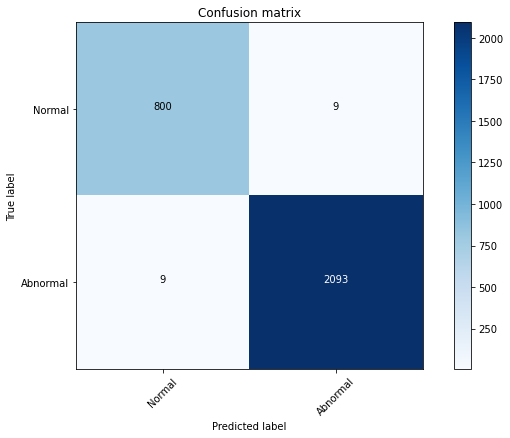

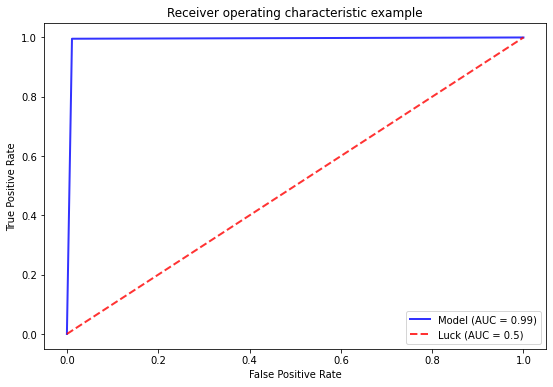

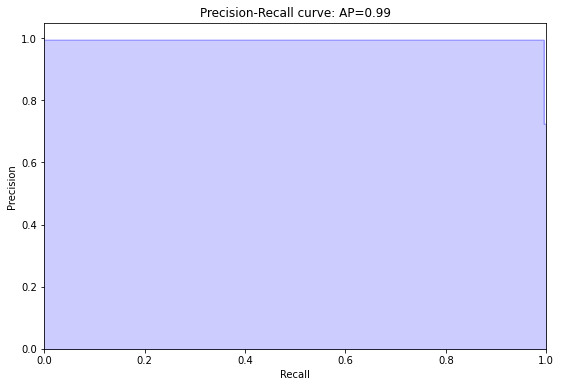

In [15]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [16]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/04-Task4\TFCNN_ptbdb\assets
